In [68]:
!pip install spotipy pandas numpy matplotlib missingno scipy seaborn statsmodels sklearn tensorflow

In [212]:
# Importer les bibliothèques nécessaires
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import csv
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import re

# **Data Acquisition**

## **Acquisition from API**

In [3]:
# Configurer les informations d'authentification
client_id = '94b56089f9144cc9bd0ab9a7d6bd238d'
client_secret = '8715a48fa8c14ce7b54b88659d00e214'
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [207]:
# Récupérer les données de la playlist Top 2012 - 2022 de Spotify
audio_features = []
playlists = []
playlist_uris = [
    '37i9dQZF1DX18jTM2l2fJY', # 2022
    '37i9dQZF1DWTqOsMG7SsUt', # 2021
    '37i9dQZF1DX7Jl5KP2eZaS', # 2020
    '37i9dQZF1DWVRSukIED0e9', # 2019
    '37i9dQZF1DXe2bobNYDtW8', # 2018
    '37i9dQZF1DWTE7dVUebpUW', # 2017
    '37i9dQZF1DX8XZ6AUo9R4R', # 2016
    '37i9dQZF1DX9ukdrXQLJGZ', # 2015
    '37i9dQZF1DX0h0QnLkMBl4', # 2014
    '37i9dQZF1DX3Sp0P28SIer', # 2013
    '37i9dQZF1DX0yEZaMOXna3'  # 2012
]

for uri in playlist_uris:
    p = sp.playlist(f'spotify:playlist:{uri}')
    af = sp.audio_features([item['track']['id'] for item in p['tracks']['items']])
    playlists.append(p)
    audio_features.append(af)

### **dataset modeling**

In [217]:
data = [];

print([int(re.sub(r'[^0-9]', '', p['name'])) for p in playlists]);
print(len(audio_features))

# for p in playlists:
#     for index, item in enumerate(playlist['tracks']['items']):
#         # playlist details
#         track = {};
#         track['rank'] = index
#         track['playlist_name'] = playlist['name']
#         track['playlist_uri'] = playlist['uri']
#         track['playlist_image'] = playlist['images'][0]['url']
#         track['playlist_snapshot_id'] = playlist['snapshot_id']
#         track['playlist_tracks_url'] = playlist['tracks']['href']
#         track['playlist_tracks_total'] = playlist['tracks']['total']

#         #tracks items details
#         track['artist_name'] = item['track']['artists'][0]['name']
#         track['album_name'] = item['track']['album']['name']

#         track['track_name'] = item['track']['name']
#         track['track_uri'] = item['track']['id']
#         track['track_added_at'] = item['added_at']
#         track['track_preview_url'] = item['track']['preview_url']
#         track['track_popularity'] = item['track']['popularity']

#         # audio features
#         features = [features for features in audio_features if features['id'] == item['track']['id']]
#         features = features[0]

#         track['danceability'] = features['danceability']
#         track['energy'] = features['energy']
#         track['key'] = features['key']
#         track['loudness'] = features['loudness']
#         track['mode'] = features['mode']
#         track['speechiness'] = features['speechiness']
#         track['acousticness'] = features['acousticness']
#         track['instrumentalness'] = features['instrumentalness']
#         track['liveness'] = features['liveness']
#         track['valence'] = features['valence']
#         track['tempo'] = features['tempo']
#         track['duration_ms'] = features['duration_ms']
#         track['time_signature'] = features['time_signature']
#         data.append(track)

[2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012]
11


## **Acquisition from a file**

In [6]:
with open('data/spotify.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, data[0].keys())
    dict_writer.writeheader()
    dict_writer.writerows(data)

In [7]:
raw_df = pd.read_csv('data/spotify.csv');

# **Data Exploration**

In [8]:
print(raw_df.describe());
print(raw_df.info());

           rank  playlist_tracks_total  track_popularity  danceability  \
count  50.00000                   50.0         50.000000     50.000000   
mean   24.50000                   50.0         86.640000      0.688460   
std    14.57738                    0.0          3.456789      0.134596   
min     0.00000                   50.0         80.000000      0.380000   
25%    12.25000                   50.0         84.000000      0.601750   
50%    24.50000                   50.0         86.500000      0.699500   
75%    36.75000                   50.0         89.000000      0.799750   
max    49.00000                   50.0         93.000000      0.911000   

          energy        key  loudness       mode  speechiness  acousticness  \
count  50.000000  50.000000  50.00000  50.000000    50.000000     50.000000   
mean    0.672780   5.380000  -5.78836   0.480000     0.069120      0.236653   
std     0.128748   3.697158   1.90153   0.504672     0.052539      0.245587   
min     0.317000 

## **Data Cleaning & Shaping**

### **parsing of text**
Removing some unnecessary columns from the data frame to make the data set easier to parse and work with

In [9]:
df = raw_df[['rank','track_name', 'track_uri', 'track_added_at', 'track_popularity', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
    'time_signature', 'artist_name', 'album_name']]

### **Check for any missing values in the data set**

<AxesSubplot:>

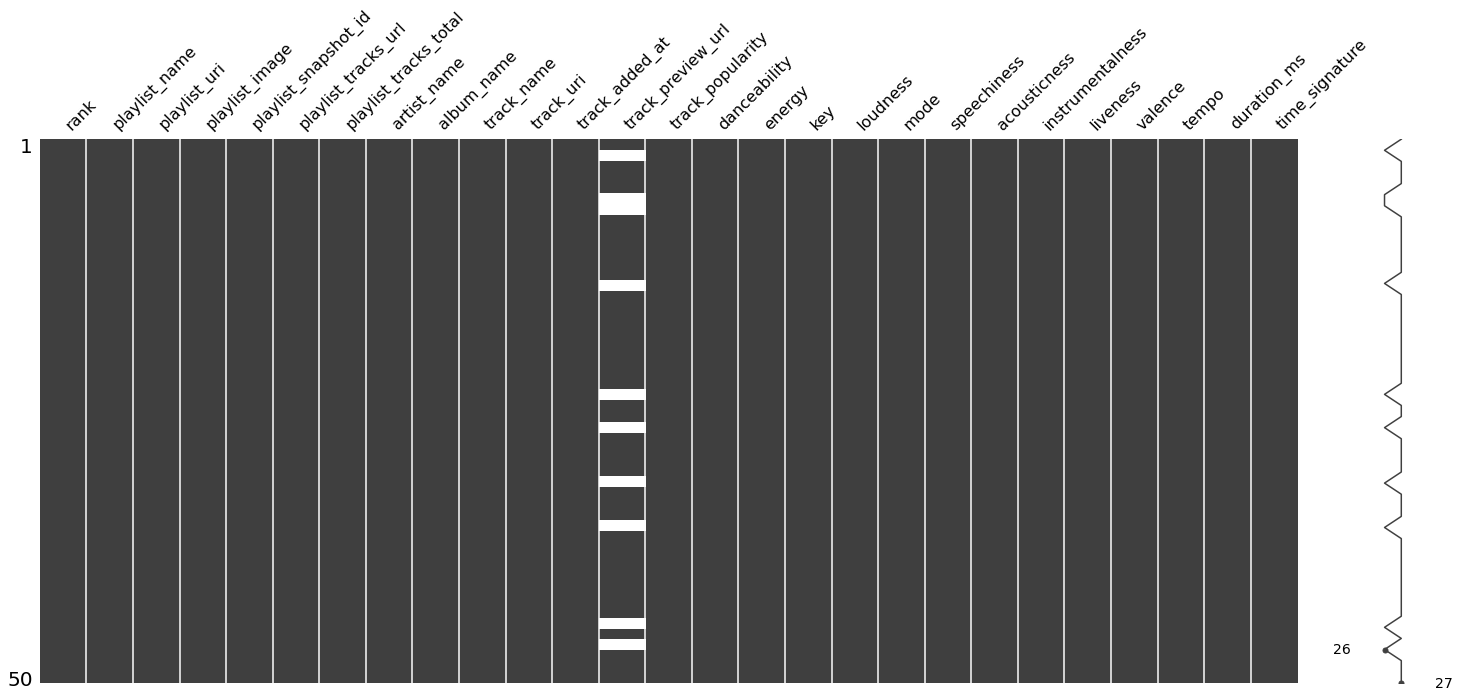

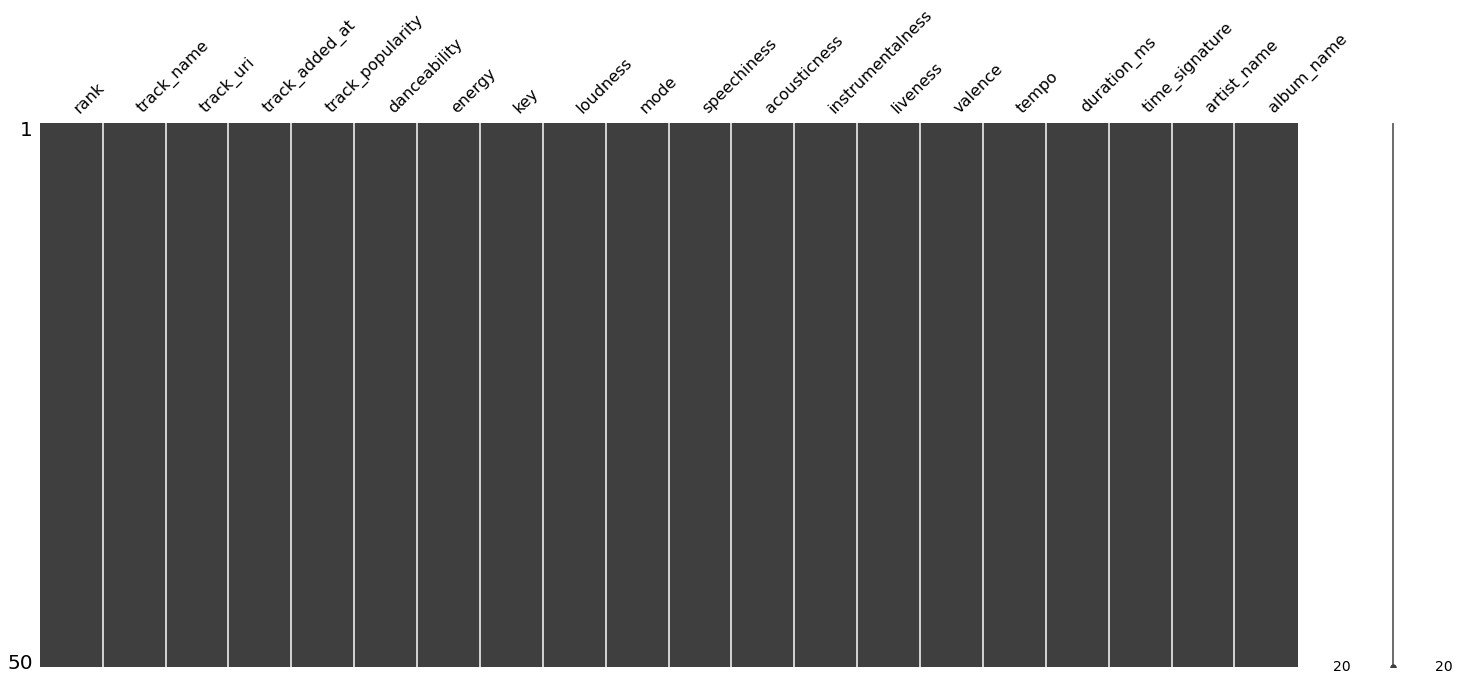

In [10]:
msno.matrix(raw_df)
msno.matrix(df)

This is a pretty small and clean data set, and there's no missing values out of the 100 tracks in this playlist.


### **Normalization/standardization of feature values**

In [11]:
# convert milliseconds to seconds
df['duration_ms'].mul(1000)

# rename column from 'duration_ms' to just 'duration'
df = df.rename({'duration_ms': 'duration'}, axis=1)

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rank              50 non-null     int64  
 1   track_name        50 non-null     object 
 2   track_uri         50 non-null     object 
 3   track_added_at    50 non-null     object 
 4   track_popularity  50 non-null     int64  
 5   danceability      50 non-null     float64
 6   energy            50 non-null     float64
 7   key               50 non-null     int64  
 8   loudness          50 non-null     float64
 9   mode              50 non-null     int64  
 10  speechiness       50 non-null     float64
 11  acousticness      50 non-null     float64
 12  instrumentalness  50 non-null     float64
 13  liveness          50 non-null     float64
 14  valence           50 non-null     float64
 15  tempo             50 non-null     float64
 16  duration          50 non-null     int64  
 17 

## **Exploratory Data Plots**

Full description of audio features: https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

### **Artists with more than one track**

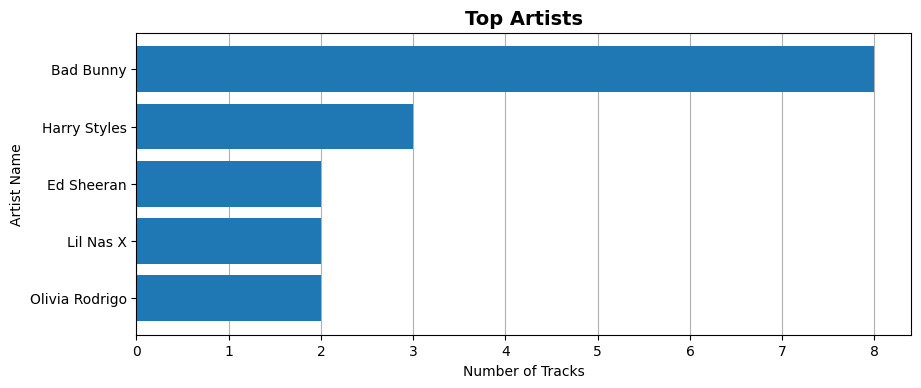

In [13]:
# Group by artist_name and count the number of tracks
top_artists = df.groupby('artist_name')['track_uri'].count().reset_index(name='count')

# Remove artists with a count less than or equal to 1
top_artists = top_artists[top_artists['count'] > 1]

# Sort the artists by count in descending order
top_artists = top_artists.sort_values('count', ascending=False)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.barh(top_artists['artist_name'], top_artists['count'], zorder=2)

# Reverse the axis so that the artist names are displayed vertically
ax.invert_yaxis()

# Set the labels and title
ax.set_xlabel("Number of Tracks")
ax.set_ylabel("Artist Name")
ax.set_title("Top Artists")

# Remove the legend and increase the size and boldness of the title
ax.title.set_size(14)
ax.title.set_weight('bold')

# Set the grid lines behind the bars
ax.grid(axis='x', zorder=0)

plt.show()

**Conclusion:** Bad Bunny and Harry Styles e were the top artists of 2017

In [14]:
def plot_audio_feature(df, label, bins=25, stats=False, density=True, limit=1):
    # Plot the histogram
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
    ax.hist(df, bins=bins, color='dodgerblue', edgecolor='white')

    # Plot the density curve
    if (density == True):
        ax2 = ax.twinx()
        sns.kdeplot(df, color='red', linewidth=2, ax=ax2)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.yaxis.set_visible(False)

    # Set the labels and title
    ax.set_xlabel(label)
    ax.set_ylabel("Count")
    ax.set_title(f'Audio Feature: {label}')
    ax.title.set_size(14)
    ax.title.set_weight('bold')


    # Set axes limits
    ax.set_xlim([0, limit])

    plt.show();
    if (stats == True):
        print("Maximum value :", round(df.max(), 2))
        print("Minimum value :", round(df.min(), 2))
        print("Mean value : ", round(df.mean(), 2))
        print("The variance :", round(df.var(), 2))
        print("The Standard deviation : ", round(df.std(), 2))

### **Danceability** 
Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

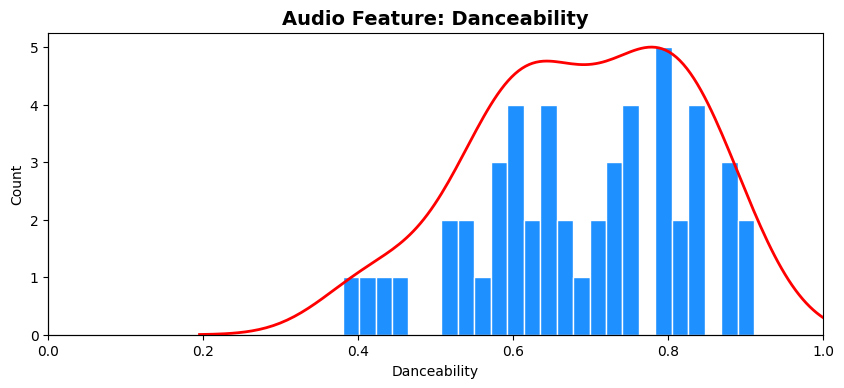

Maximum value : 0.91
Minimum value : 0.38
Mean value :  0.69
The variance : 0.02
The Standard deviation :  0.13


In [30]:
plot_audio_feature(df['danceability'], label="Danceability", stats=True)

### **Energy**

A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks 
feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

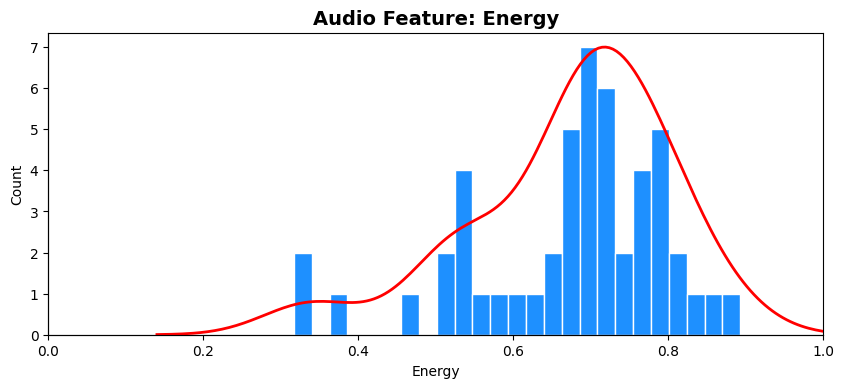

Maximum value : 0.89
Minimum value : 0.32
Mean value :  0.67
The variance : 0.02
The Standard deviation :  0.13


In [29]:
plot_audio_feature(df['energy'], 'Energy', stats=True)

### **Songs Key Signatures**

https://en.wikipedia.org/wiki/Key_signature

In [31]:
df['key_name'] = None

df['key_name'].where(~(df['key'] == 0), "C", inplace=True)
df['key_name'].where(~(df['key'] == 1), "C#", inplace=True)
df['key_name'].where(~(df['key'] == 2), "D", inplace=True)
df['key_name'].where(~(df['key'] == 3), "D#", inplace=True)
df['key_name'].where(~(df['key'] == 4), "E", inplace=True)
df['key_name'].where(~(df['key'] == 5), "F", inplace=True)
df['key_name'].where(~(df['key'] == 6), "F#", inplace=True)
df['key_name'].where(~(df['key'] == 7), "G", inplace=True)
df['key_name'].where(~(df['key'] == 8), "G#", inplace=True)
df['key_name'].where(~(df['key'] == 9), "A", inplace=True)
df['key_name'].where(~(df['key'] == 10), "A#", inplace=True)
df['key_name'].where(~(df['key'] == 11), "B", inplace=True)

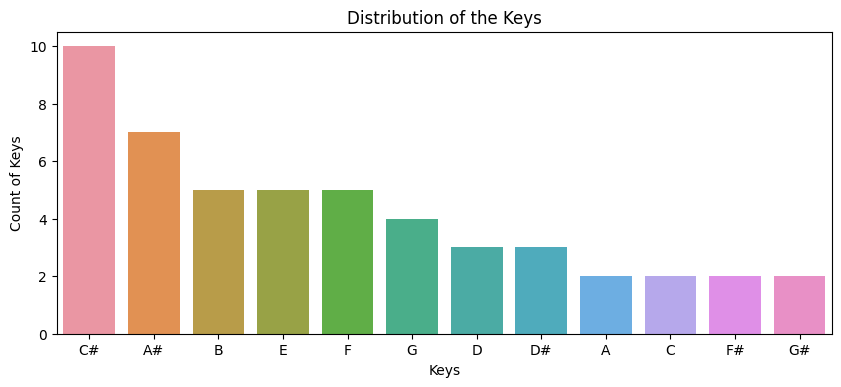

In [33]:
# group by 'key' and calculate the count of each key
song_keys = df.groupby('key_name').size().reset_index(name='n_key')

# sort the keys by count of occurrences
song_keys = song_keys.sort_values('n_key', ascending=False)

# sort categorical order
song_keys['key_name'] = pd.Categorical(song_keys['key_name'], categories=song_keys['key_name'].tolist())

# plot the bar graph
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.barplot(x='key_name', y='n_key', data=song_keys)
ax.set_title('Distribution of the Keys')
ax.set_xlabel('Keys')
ax.set_ylabel('Count of Keys')

plt.show();

**Conclusion:** The most common key among the track was C#

### **Loudness**
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

*Note: I’ve inverted the loudness values from negative to positive*

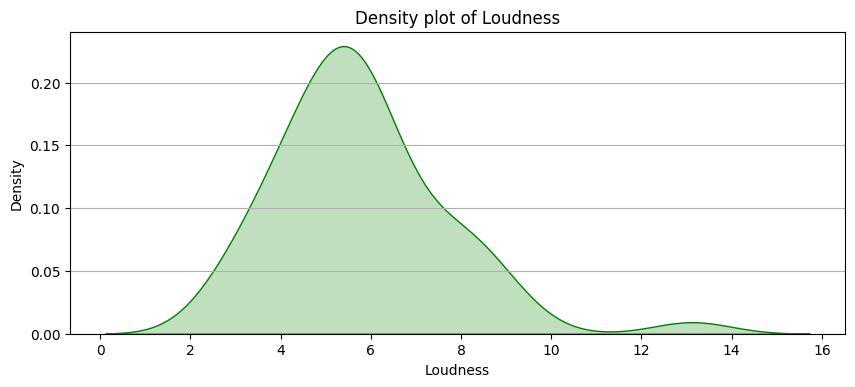

Maximum value : 13.12
Minimum value : 2.72
Mean value :  5.79
The variance : 3.62
The Standard deviation :  1.9


In [21]:
# extraire la variable loudness
loudness = df['loudness'] * -1

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.kdeplot(loudness, shade=True, color='green')

ax.set_title('Density plot of Loudness')
ax.set_xlabel('Loudness')
ax.set_ylabel('Density')
ax.yaxis.grid(True)

plt.show();
print("Maximum value :", round(loudness.max(), 2))
print("Minimum value :", round(loudness.min(), 2))
print("Mean value : ", round(loudness.mean(), 2))
print("The variance :", round(loudness.var(), 2))
print("The Standard deviation : ", round(loudness.std(), 2))

### **Mode**
Indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

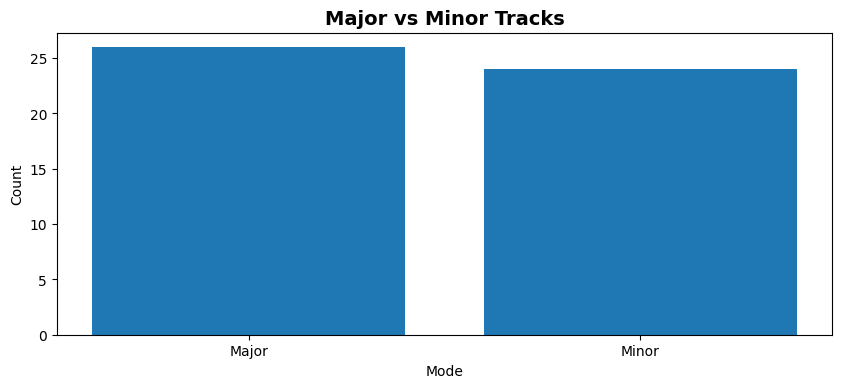

In [22]:
mode = df
mode['mode'].where(~(df['mode'] == 0), 'Major', inplace=True)
mode['mode'].where(~(df['mode'] == 1), 'Minor', inplace=True)

plt.figure(figsize=(10, 4), dpi=100)
plt.xlabel('Mode')
plt.ylabel('Count')
plt.title('Major vs Minor Tracks', fontweight='bold', fontsize=14)

labels, counts = np.unique(mode['mode'], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show();

**Conclusion**: Major key tracks are preferred over minor key tracks. This is expected, since major key sounds happier than minor key.

### **Speechiness**
Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

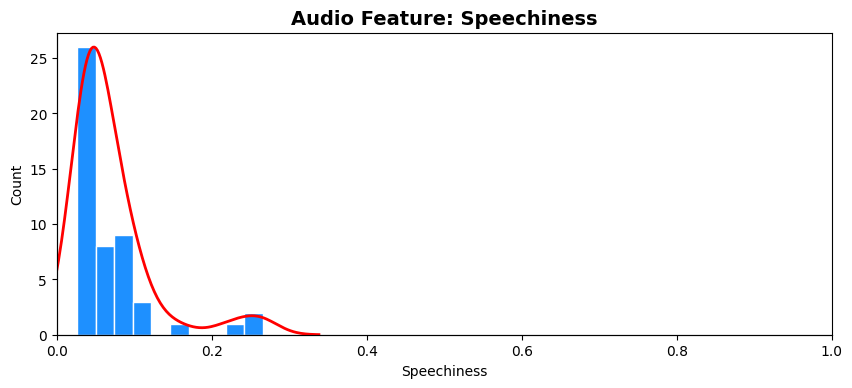

Maximum value : 0.27
Minimum value : 0.03
Mean value :  0.07
The variance : 0.0
The Standard deviation :  0.05


In [34]:
plot_audio_feature(df['speechiness'], 'Speechiness', bins=10, stats=True)

### **Acousticness**
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

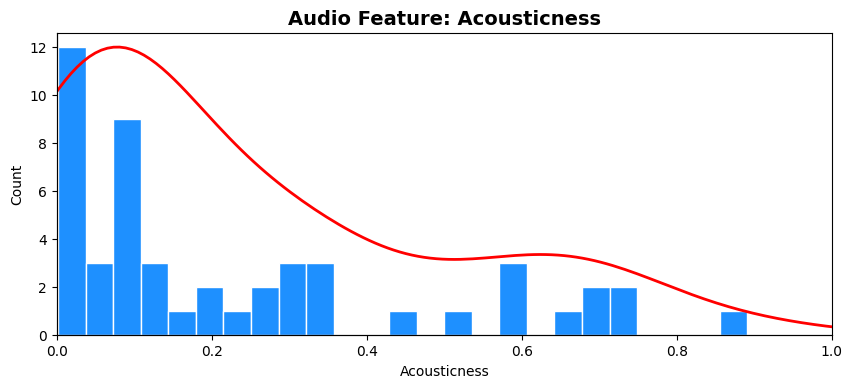

Maximum value : 0.89
Minimum value : 0.0
Mean value :  0.24
The variance : 0.06
The Standard deviation :  0.25


In [35]:
plot_audio_feature(df['acousticness'], 'Acousticness', stats=True)

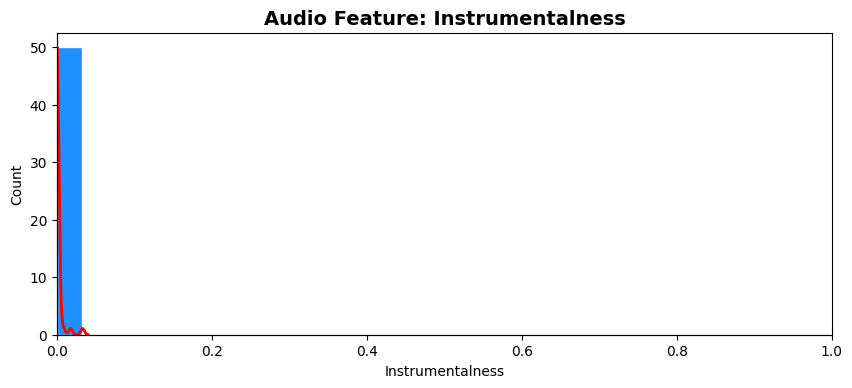

In [145]:
plot_audio_feature(df['instrumentalness'], 'Instrumentalness', bins=1)

### **Liveness**
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

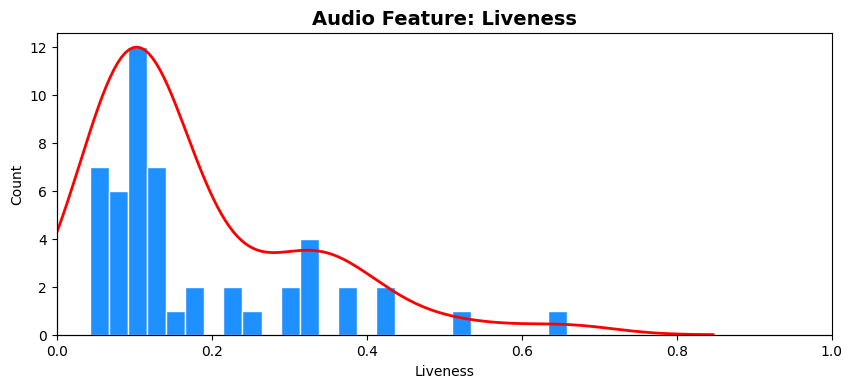

Maximum value : 0.66
Minimum value : 0.04
Mean value :  0.18
The variance : 0.02
The Standard deviation :  0.14


In [36]:
plot_audio_feature(df['liveness'], 'Liveness', stats=True)

### **Valence**
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

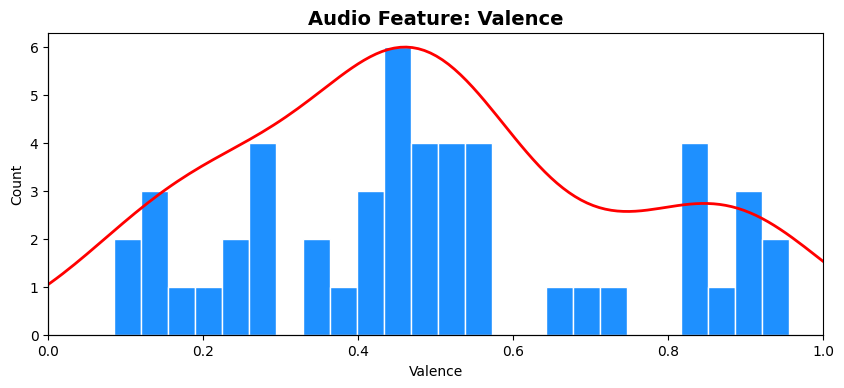

Maximum value : 0.96
Minimum value : 0.08
Mean value :  0.49
The variance : 0.06
The Standard deviation :  0.25


In [37]:
plot_audio_feature(df['valence'], 'Valence', stats=True)

### **Correlation/collinearity analysis**
In order to understand the correlation between variables, I’ll use corrplot function, which is one of the base data visualization functions.

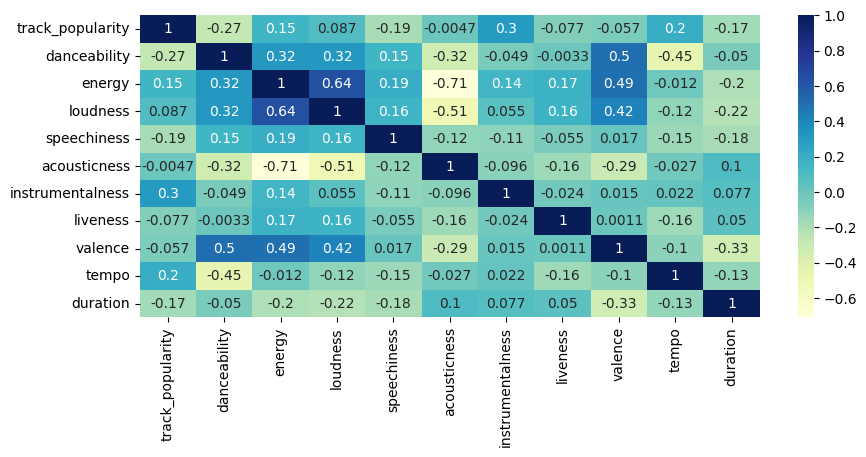

In [147]:
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.heatmap(df[[
    'track_popularity',
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration',
]].corr(), cmap="YlGnBu", annot=True);

It looks like speechiness and loudness are positively correlated with each other.

Also, valence is positively correlated with danceability and energy. Considering happy songs make people energetic and want to dance, the correlation obviously makes sense.

Interestingly enough, tempo and danceability are very negatively correlated.

As seen above, energy, valence, and danceability are positively correlated. Let’s see how these variables are distributed

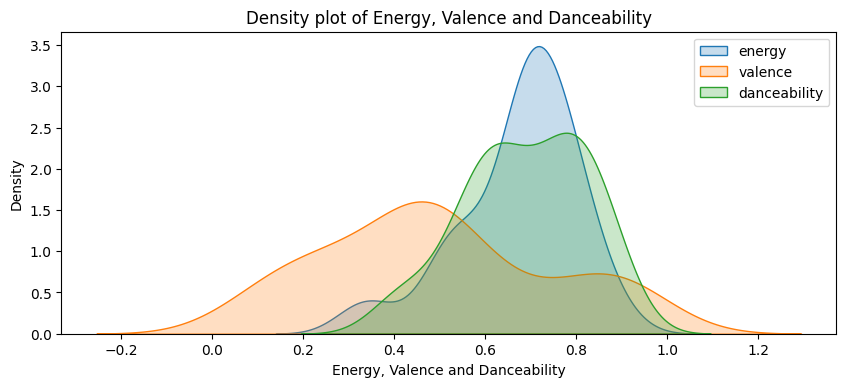

In [39]:
plt.figure(figsize=(10, 4), dpi=100)
sns.kdeplot(df['energy'], shade=True, label="energy")
sns.kdeplot(df['valence'], shade=True, label="valence")
sns.kdeplot(df['danceability'], shade=True, label="danceability")


plt.xlabel('Energy, Valence and Danceability')
plt.ylabel('Density')
plt.title('Density plot of Energy, Valence and Danceability')

plt.legend()
plt.show();

### **Tempo**
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

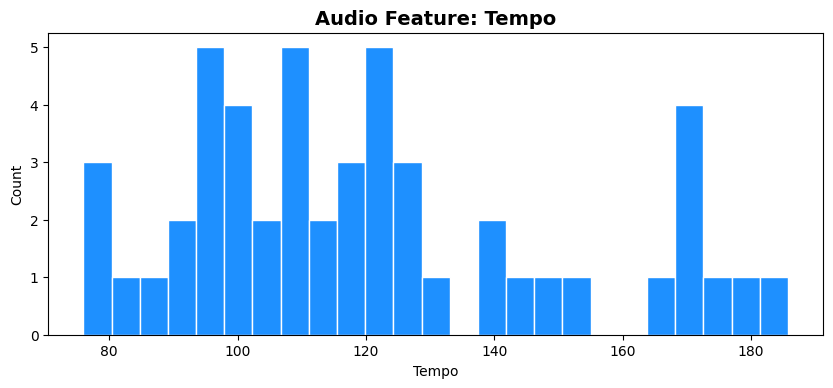

Maximum value : 185.73
Minimum value : 75.98
Mean value :  120.62
The variance : 859.34
The Standard deviation :  29.31


In [40]:
tempo = df['tempo']

# Plot the histogram
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.hist(tempo, bins=25, color='dodgerblue', edgecolor='white')

# Set the labels and title
ax.set_xlabel("Tempo")
ax.set_ylabel("Count")
ax.set_title("Audio Feature: Tempo")
ax.title.set_size(14)
ax.title.set_weight('bold')

# Set axes limits

plt.show();
print("Maximum value :", round(tempo.max(), 2))
print("Minimum value :", round(tempo.min(), 2))
print("Mean value : ", round(tempo.mean(), 2))
print("The variance :", round(tempo.var(), 2))
print("The Standard deviation : ", round(tempo.std(), 2))

**[Tempo Markings](https://en.wikipedia.org/wiki/Tempo)**

- Grave – very slow (25–45 bpm)
- Largo – broadly (40–60 bpm)
- Larghetto – rather broadly (60–66 bpm)
- Adagio – slowly with great expression (66–76 bpm)
- Andante – at a walking pace (76–108 bpm)
- Moderato – at a moderate speed (108–120 bpm)
- Allegro – fast, quickly, and bright (120–156 bpm)
- Vivace – lively and fast (156–176 bpm)
- Presto – very, very fast (176–200 bpm)
- Prestissimo – even faster than presto (200 bpm and over)

In [59]:
df['tempo_marking'] = None    
df['tempo_marking'].where(~(df['tempo'] > 25) & (df['tempo'] < 45), "grave", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 45) & (df['tempo'] < 60), "largo", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 60) & (df['tempo'] < 66), "larghetto", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 66) & (df['tempo'] < 76), "adagio", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 76) & (df['tempo'] < 108), "andante", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 108) & (df['tempo'] < 120), "moderato", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 120) & (df['tempo'] < 156), "allegro", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 156) & (df['tempo'] < 176), "vivace", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 176) & (df['tempo'] < 200), "presto", inplace=True)
df['tempo_marking'].where(~(df['tempo'] > 200), "prestissimo", inplace=True)

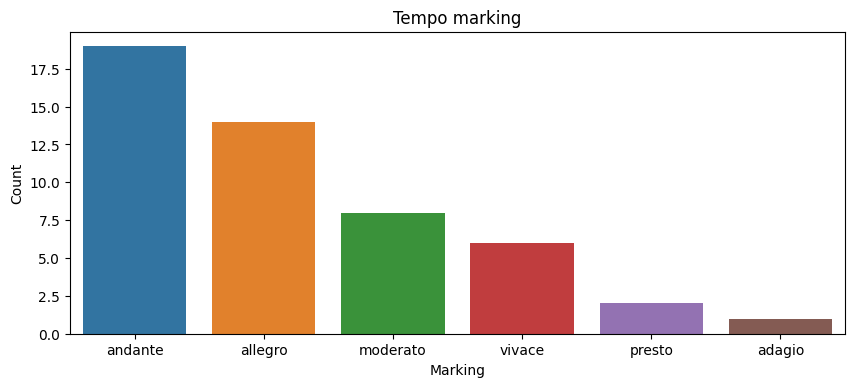

In [61]:
# group by 'key' and calculate the count of each key
song_keys = df.groupby('tempo_marking').size().reset_index(name='n_key')

# sort the keys by count of occurrences
song_keys = song_keys.sort_values('n_key', ascending=False)

# sort categorical order
song_keys['tempo_marking'] = pd.Categorical(song_keys['tempo_marking'], categories=song_keys['tempo_marking'].tolist())

# plot the bar graph
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.barplot(x='tempo_marking', y='n_key', data=song_keys)
ax.set_title('Tempo marking')
ax.set_xlabel('Marking')
ax.set_ylabel('Count')

plt.show();

# **Model Construction and Evaluation**

## **Training & validation subsets**

In [182]:
dfm = df[[
    'danceability',
    'energy',
    'loudness',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration',
    'track_popularity',
]]

# Séparation des données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(
    dfm.drop('track_popularity', axis=1), 
    dfm['track_popularity'], 
    test_size=0.2, 
    random_state=0
)

## **Logistic Regression Model**
Linear regression is one of the most widely known modeling techniques. It allows you, in short, to use a linear relationship to predict the (average) numerical value of Y for a given value of X with a straight line. This line is called the “regression line”.

As a consequence, the linear regression model is y = ax + b. The model assumes that the response variable y is quantitative.

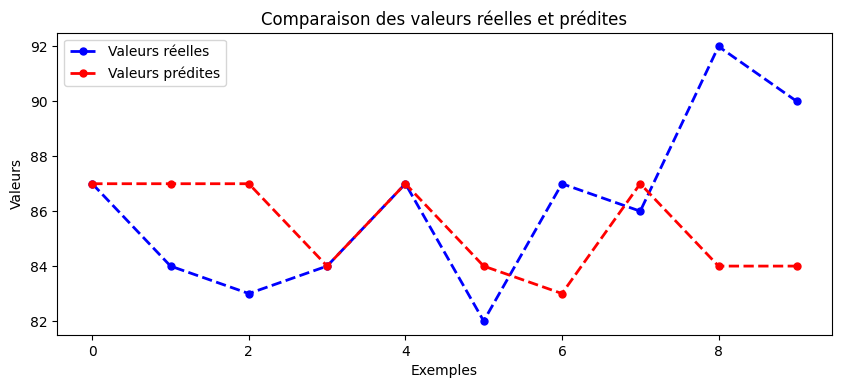

model score :  0.3


In [183]:
# Création du modèle de régression linéaire
# Entraînement du modèle sur l'ensemble d'entraînement
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédiction de la popularité des chansons dans l'ensemble de test
# Calcul de l'erreur moyenne au carré pour évaluer la performance du modèle
y_pred = model.predict(X_test)

# plot
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
plt.plot(range(len(y_test)), y_test, 'o--', linewidth=2, markersize=5, c='b', label='Valeurs réelles')
plt.plot(range(len(y_test)), y_pred,'o--', linewidth=2, markersize=5, c='r', label='Valeurs prédites')
plt.xlabel('Exemples') 
plt.ylabel('Valeurs')
plt.title('Comparaison des valeurs réelles et prédites')
plt.legend()
plt.show()

print(f'model score :  {model.score(X_test, y_test)}')

## **Neural Network Model**
Linear regression is one of the most widely known modeling techniques. It allows you, in short, to use a linear relationship to predict the (average) numerical value of Y for a given value of X with a straight line. This line is called the “regression line”.

As a consequence, the linear regression model is y = ax + b. The model assumes that the response variable y is quantitative.

In [193]:
def plot_history_loss(history):
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [204]:
data = X_train.to_numpy()

normalizer = tf.keras.layers.Normalization(input_shape=(10, 1), axis=-1)
normalizer.adapt(data)

nn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [205]:
history = nn_model.fit(X_train, y_train, epochs=100)

Epoch 1/100
2/2 [==============================] - 1s 5ms/step - loss: 29197955072.0000
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 15598914560.0000
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 10971689984.0000
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 5622972928.0000
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 3968155648.0000
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 2412112640.0000
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 1363338752.0000
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 647570560.0000
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 234374784.0000
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 36982664.0000
Epoch 11/100
2/2 [==============================] - 0s 6ms/step - loss: 4315141.5000
Epoch 12/100
2/2 [===========================

2/2 [==============================] - 0s 5ms/step - loss: 11620858.0000
Epoch 99/100
2/2 [==============================] - 0s 6ms/step - loss: 12762566.0000
Epoch 100/100
2/2 [==============================] - 0s 6ms/step - loss: 28689242.0000


In [199]:
print(history.history)

{'loss': [1988401299456.0, 1269510701056.0, 765591158784.0, 412125331456.0, 168985526272.0, 50200088576.0, 4605102592.0, 5520204800.0, 29873760256.0, 58000027648.0, 78120443904.0, 81633239040.0, 73858744320.0, 59235262464.0, 42557607936.0, 26382968832.0, 13365340160.0, 5134312448.0, 868085952.0, 114498992.0, 1409003008.0, 3539871744.0, 5352192512.0, 6247708160.0, 6102664192.0, 5148591616.0, 3669202432.0, 2215469568.0, 1031322624.0, 333600832.0, 17963270.0, 89408288.0, 345699392.0, 600026496.0, 732884032.0, 718535488.0, 582460096.0, 393459136.0, 208695632.0, 71963904.0, 9057758.0, 6412092.0, 33079820.0, 67577008.0, 89837432.0, 91731888.0, 75223728.0, 49982092.0, 24928198.0, 7533794.5, 782340.3125, 1183626.5, 1742752.375, 268616.53125, 1218367.25, 71974.6328125, 785720.3125, 140456.640625, 352581.09375, 237491.953125, 102581.9453125, 257885.625, 23197.203125, 161918.921875, 29895.671875, 83372.375, 55551.41796875, 27983.22265625, 56465.6015625, 8895.0244140625, 39647.3046875, 9290.162109